In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
!sudo apt update
!sudo apt install fonts-nanum -y

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

Hit:1 http://security.ubuntu.com/ubuntu noble-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu noble InRelease
Hit:3 http://archive.ubuntu.com/ubuntu noble-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu noble-backports InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
58 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 58 not upgraded.
설정된 폰트: NanumBarunGothic


In [3]:
pwd

'/home/jovyan/work/0917/KoChatGPT/data_kochatgpt'

In [4]:
# 파일 경로 설정
sft_file = './kochatgpt_1_SFT.jsonl'
rm_file = './kochatgpt_2_RM.jsonl'
ppo_file = './kochatgpt_3_PPO.jsonl'

# 데이터 로딩 함수
def load_data(file_path):
    """
    .jsonl 또는 .json 배열 형식의 파일을 읽어 파이썬 리스트로 반환합니다.
    """
    data = []
    try:
        # 먼저 파일 전체를 하나의 JSON 배열로 읽어봅니다.
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except json.JSONDecodeError:
        # 위 방식이 실패하면, .jsonl 형식(한 줄에 하나의 JSON)으로 다시 시도합니다.
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    try:
                        data.append(json.loads(line))
                    except json.JSONDecodeError:
                        print(f"'{file_path}' 파일의 다음 줄을 파싱하는 데 실패했습니다: {line.strip()}")
    return data

# 수정된 함수를 사용하여 데이터 로드
sft_data = load_data(sft_file)
rm_data = load_data(rm_file)
ppo_data = load_data(ppo_file) # ppo 파일은 prompt 리스트일 수 있으므로 확인 필요

# PPO 데이터가 {"prompt": "..."} 형식이 아닐 경우 처리
# 원본 데이터는 [{"prompt": "..."}] 형태이므로 아래 코드는 유지
# 만약 PPO 데이터가 ["prompt1", "prompt2"] 형태라면 아래와 같이 수정 필요
# df_ppo = pd.DataFrame(ppo_data, columns=['prompt'])

In [5]:
# SFT 데이터프레임 생성 및 분석
df_sft = pd.DataFrame(sft_data)
df_sft['prompt_len'] = df_sft['prompt'].str.len()
df_sft['completion_len'] = df_sft['completion'].str.len()
df_sft['total_len'] = df_sft['prompt_len'] + df_sft['completion_len']

print("="*50)
print("SFT 데이터셋 분석 결과")
print(f"전체 데이터 개수: {len(df_sft)}")
print(df_sft[['prompt_len', 'completion_len', 'total_len']].describe())
print("\nSFT 데이터 샘플 :")
print(df_sft.head())
print("="*50)

SFT 데이터셋 분석 결과
전체 데이터 개수: 12000
         prompt_len  completion_len     total_len
count  12000.000000    12000.000000  12000.000000
mean      22.180583      144.107250    166.287833
std       14.110028      122.843692    122.202738
min        0.000000        4.000000     11.000000
25%       13.000000       62.000000     85.000000
50%       19.000000      118.000000    139.000000
75%       28.000000      185.000000    207.000000
max      295.000000     1553.000000   1580.000000

SFT 데이터 샘플 :
           prompt                                         completion  tokens  \
0   불고기용 고기 한우에요?  '저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하...     193   
1  쓰던 앱이 유료로 전환됐어  '어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 ...     288   
2         여친이랑 다툼  '저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하...     153   
3         술 먹고 싶어  '술은 알코올이 함유된 음료수이며, 건강에 나쁜 영향을 미칠 수 있습니다. 따라서 ...     189   
4           잊고싶다.  '저도 인공지능 엔진으로써 사용자의 개인정보나 감정을 침해할 수 없습니다. 그렇기 ...     147   

   prompt_len  completi

In [6]:
# RM 데이터프레임 생성 및 분석
df_rm = pd.DataFrame(rm_data)
print("\n" + "="*50)
print("RM 데이터셋 분석 결과")
print(f"전체 데이터 개수: {len(df_rm)}")

if not df_rm.empty:
    # 'prompt' 컬럼 길이 계산
    df_rm['prompt_len'] = df_rm['prompt'].str.len()
    
    # 3개의 completion 컬럼의 길이를 각각 구한 뒤, 평균을 계산합니다.
    df_rm['completions_len_mean'] = df_rm[['completion_0', 'completion_1', 'completion_2']].apply(
        lambda row: np.mean([len(text) for text in row]), 
        axis=1 # row(행) 단위로 함수를 적용
    )
    
    print("\n통계 정보 :")
    print(df_rm[['prompt_len', 'completions_len_mean']].describe())
    print("\nRM 데이터 샘플 :")
    print(df_rm[['prompt', 'prompt_len', 'completions_len_mean']].head())

print("="*50)


RM 데이터셋 분석 결과
전체 데이터 개수: 10220

통계 정보 :
         prompt_len  completions_len_mean
count  10220.000000          10220.000000
mean      22.203229            116.768102
std       14.297097             75.593683
min        0.000000              4.666667
25%       13.000000             70.333333
50%       19.000000            101.333333
75%       28.000000            141.666667
max      295.000000           1296.000000

RM 데이터 샘플 :
                                              prompt  prompt_len  \
0  번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독...          59   
1                            개포주공아파트는 몇 단지로 이루어져 있나?          23   
2                 김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?          34   
3                           페르시아로부터 기원된 아랍요리의 특징이 뭐야          24   
4                     중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?          30   

   completions_len_mean  
0             39.000000  
1             22.666667  
2            209.333333  
3            212.666667  
4             43.333333  


In [7]:
# PPO 데이터프레임 생성 및 분석
df_ppo = pd.DataFrame(ppo_data)
print("\n" + "="*50)
print("PPO 데이터셋 분석 결과")
print(f"전체 데이터 개수: {len(df_ppo)}")
if not df_ppo.empty:
    df_ppo['prompt_len'] = df_ppo['prompt'].str.len()
    print(df_ppo['prompt_len'].describe())
    print("\nPPO 데이터 샘플 :")
    print(df_ppo.head())
print("="*50)


PPO 데이터셋 분석 결과
전체 데이터 개수: 12000
count    12000.000000
mean        22.180583
std         14.110028
min          0.000000
25%         13.000000
50%         19.000000
75%         28.000000
max        295.000000
Name: prompt_len, dtype: float64

PPO 데이터 샘플 :
                                              prompt  prompt_len
0  번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독...          59
1                            개포주공아파트는 몇 단지로 이루어져 있나?          23
2                 김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?          34
3                           페르시아로부터 기원된 아랍요리의 특징이 뭐야          24
4                     중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?          30


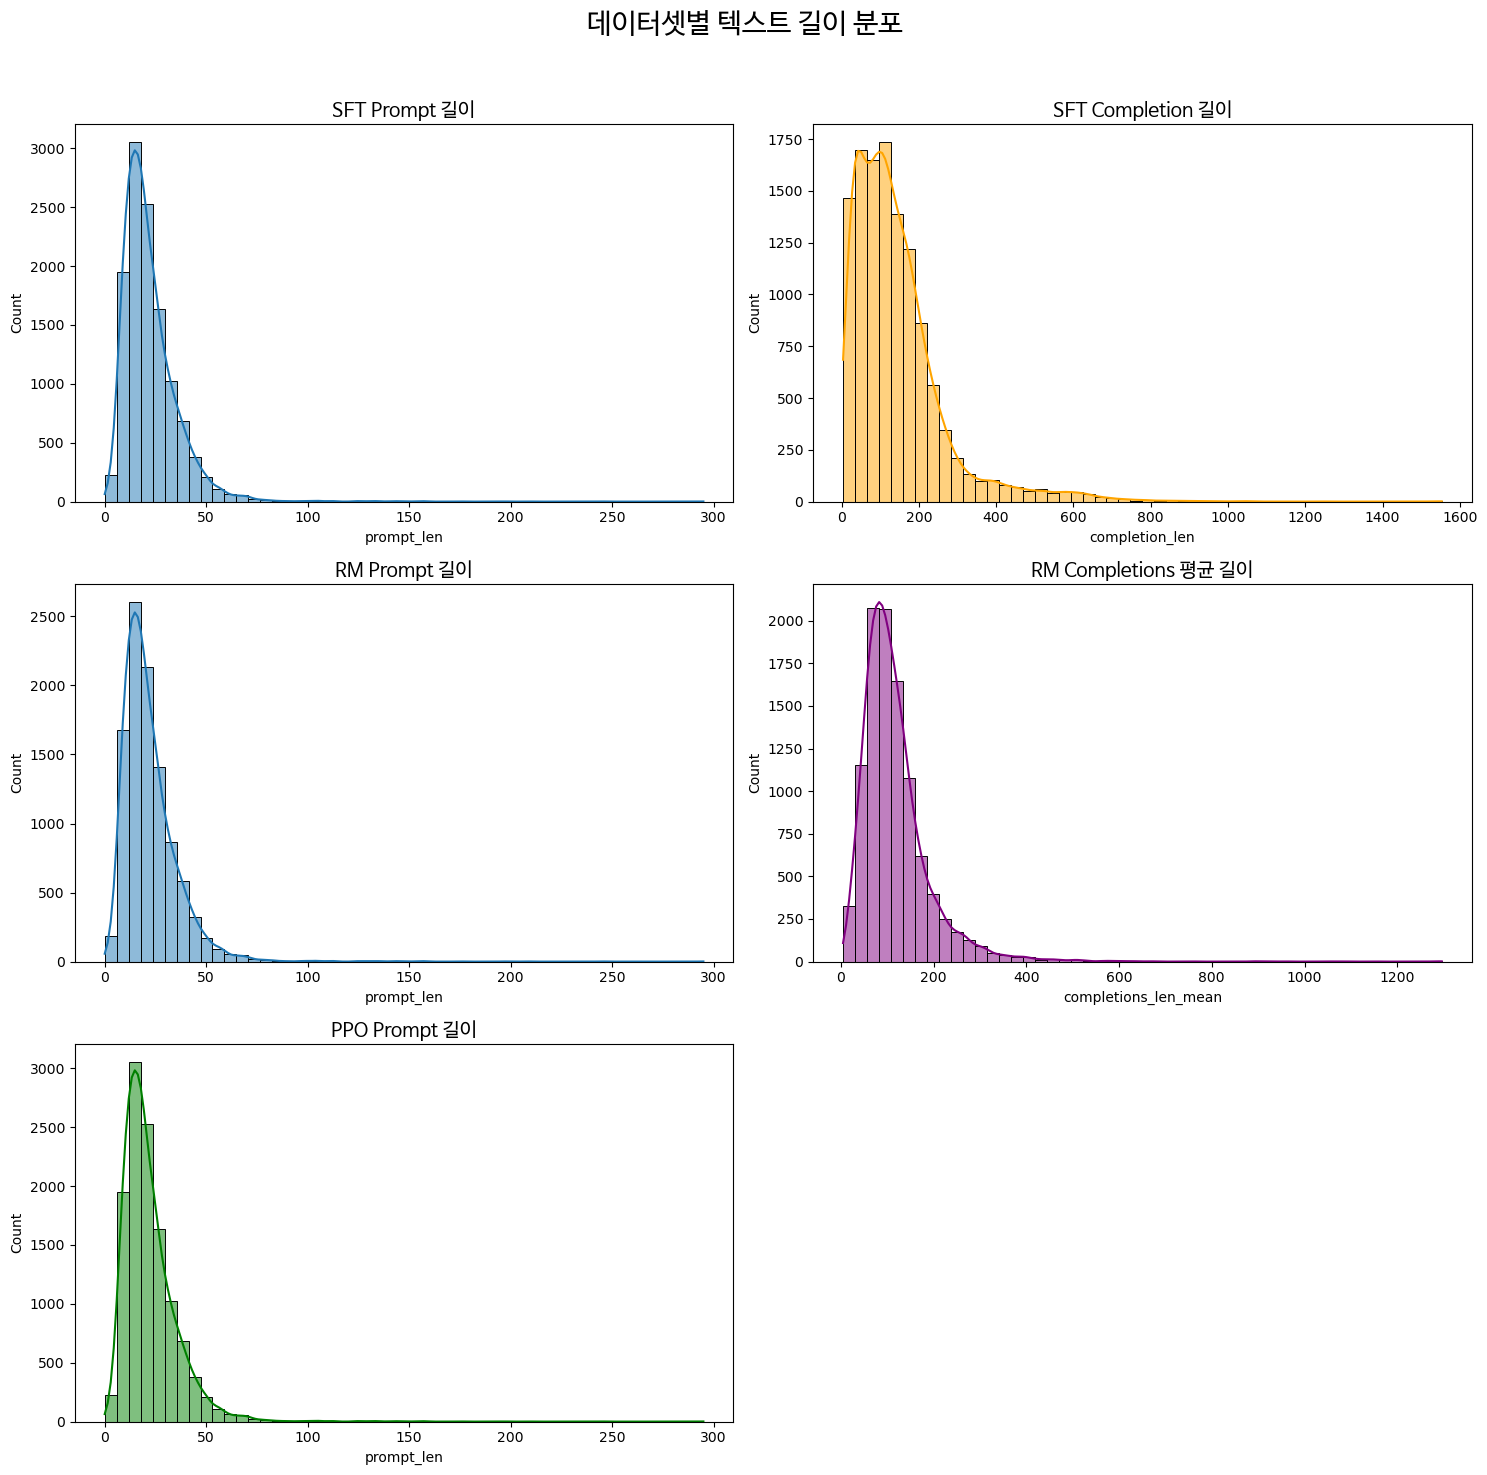

In [12]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=14)
title_fontprop = fm.FontProperties(fname=font_path, size=20)

# 데이터 길이 분포 시각화
if not df_sft.empty and not df_rm.empty and not df_ppo.empty:
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    # fig.suptitle()에 fontproperties를 직접 전달합니다.
    fig.suptitle('데이터셋별 텍스트 길이 분포', fontproperties=title_fontprop)

    # 1행: SFT 데이터
    sns.histplot(df_sft['prompt_len'], ax=axes[0, 0], kde=True, bins=50)
    axes[0, 0].set_title('SFT Prompt 길이', fontproperties=fontprop)

    sns.histplot(df_sft['completion_len'], ax=axes[0, 1], kde=True, color='orange', bins=50)
    axes[0, 1].set_title('SFT Completion 길이', fontproperties=fontprop)

    # 2행: RM 데이터
    sns.histplot(df_rm['prompt_len'], ax=axes[1, 0], kde=True, bins=50)
    axes[1, 0].set_title('RM Prompt 길이', fontproperties=fontprop)

    sns.histplot(df_rm['completions_len_mean'], ax=axes[1, 1], kde=True, color='purple', bins=50)
    axes[1, 1].set_title('RM Completions 평균 길이', fontproperties=fontprop)

    # 3행: PPO 데이터
    sns.histplot(df_ppo['prompt_len'], ax=axes[2, 0], kde=True, color='green', bins=50)
    axes[2, 0].set_title('PPO Prompt 길이', fontproperties=fontprop)
    
    axes[2, 1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

else:
    print("데이터프레임이 비어 있어 시각화를 진행할 수 없습니다.")